# Demonstrate Laguerre Polynomial Dynamical System Model

In [1]:
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider

In [2]:
from platform import python_version

python_version()

'3.10.16'

In [3]:
import matplotlib
matplotlib.__version__

'3.8.4'

In [4]:
def calculate_tau_parameters(p, T):
    """
    Calculate the tau parameters from the Laguerre filter theory.
    
    Returns:
    --------
    Tuple of CasADi symbolic expressions for tau1, tau2, tau3, tau4
    """

    
    # Calculate tau parameters as per equations in the paper
    exp_pT = ca.exp(-p * T)
    
    tau1 = exp_pT
    tau2 = T + (2 / p) * (exp_pT - 1)
    tau3 = -T * exp_pT - (2 / p) * (exp_pT - 1)
    tau4 = ca.sqrt(2 * p * (1 - tau1) / p)

    return tau1, tau2, tau3, tau4

def construct_A_matrix(N, T, tau1, tau2, tau3) -> ca.SX:
    """
    Construct the A matrix based on the Laguerre filter structure.
    
    Returns:
    --------
    ca.SX: N x N state transition matrix
    """
    A = ca.SX.zeros(N, N)
    
    # Fill the diagonal with tau1
    for i in range(N):
        A[i, i] = tau1
    
    # Fill the super-diagonal elements
    for i in range(N - 1):
        if i == 0:
            # First row, second column
            A[i, i + 1] = 0
        else:
            # Other super-diagonal elements
            A[i, i + 1] = 0
    
    # Fill the sub-diagonal elements
    for i in range(1, N):
        A[i, i - 1] = -(tau1 * tau2 + tau3) / T
    
    # Fill the first column (except diagonal)
    for i in range(1, N):
        A[i, 0] = ((-1)**(i) * tau1**(i-1) * (tau1 * tau2 + tau3)) / (T**(i))
    
    return A

def construct_b_vector(N, T, tau2, tau4):
    """
    Construct the b vector (input matrix).
    
    Returns:
    --------
    ca.SX: N x 1 input vector
    """
    b = ca.SX.zeros(N)
    
    # Fill b vector according to equation (9)
    for i in range(N):
        if i == 0:
            b[i] = tau4
        else:
            b[i] = (-tau2 / T)**(i) * tau4
    
    return b

## Construct Laguerre Polynomial Model

In [5]:
N = 5
p = ca.SX.sym('p')
T = ca.SX.sym('T')

tau1, tau2, tau3, tau4 = calculate_tau_parameters(p, T)

In [6]:
A = construct_A_matrix(N, T, tau1, tau2, tau3)
assert A.shape == (N, N)
A

SX(@1=exp((-(p*T))), @2=2, @3=1, @4=(T+((@2/p)*(@1-@3))), @5=((T*@1)+((@2/p)*(@1-@3))), @6=0, 
[[@1, @6, @6, @6, @6], 
 [(-(((@1*@4)-@5)/T)), @1, @6, @6, @6], 
 [((@1*((@1*@4)-@5))/sq(T)), (-(((@1*@4)-@5)/T)), @1, @6, @6], 
 [(-((sq(@1)*((@1*@4)-@5))/(T*sq(T)))), @6, (-(((@1*@4)-@5)/T)), @1, @6], 
 [(((@1*sq(@1))*((@1*@4)-@5))/sq(sq(T))), @6, @6, (-(((@1*@4)-@5)/T)), @1]])

In [7]:
b = construct_b_vector(N, T, tau2, tau4)
assert b.shape == (N, 1)
b

SX(@1=2, @2=1, @3=exp((-(p*T))), @4=sqrt((((@1*p)*(@2-@3))/p)), @5=(T+((@1/p)*(@3-@2))), @6=(@5/T), [@4, (-((@5/T)*@4)), (sq((@5/T))*@4), (-((@6*sq(@6))*@4)), (sq(sq((@5/T)))*@4)])

In [8]:
def make_state_transition_function(N):
    p = ca.SX.sym('p')
    T = ca.SX.sym('T')
    tau1, tau2, tau3, tau4 = calculate_tau_parameters(p, T)
    A = construct_A_matrix(N, T, tau1, tau2, tau3)
    assert A.shape == (N, N)
    b = construct_b_vector(N, T, tau2, tau4)
    x = ca.SX.sym('x', N)
    u = ca.SX.sym('u')
    assert b.shape == (N, 1)
    f = ca.Function("f", [x, u, p, T], [A @ x + b @ u], ['xk', 'uk', 'p', 'T'], ['xkp1'])
    return f

N = 3
f = make_state_transition_function(N)
x = ca.DM.zeros(N)
u = ca.DM(0)
p = ca.DM(0.5)
T = ca.DM(0.5)
assert np.allclose(f(x, u, p, T), [0.0, 0.0, 0.0])

In [9]:
def make_output_function(N):
    x = ca.SX.sym('x', N)
    u = ca.SX.sym('u')
    c = ca.SX.sym('c', N)
    h = ca.Function("h", [x, u, c], [c.T @ x], ['xk', 'uk', 'c'], ['yk'])
    return h

N = 3
h = make_output_function(N)
x = ca.DM.zeros(N)
u = ca.DM(0)
c = ca.DM.ones(N)
assert np.allclose(h(x, u, c), [0.0])

## Simulate step response

In [10]:
def make_step_response_function(N, T, nT, k_step=2):

    # Construct Laguerre polynomial state transition function
    f = make_state_transition_function(N)
    h = make_output_function(N)

    # Sample period
    T = ca.DM(T)

    # System parameters (variable)
    p = ca.SX.sym('p')
    c = ca.SX.sym('c', N)

    # Unit step input
    U = ca.DM.zeros(nT+1, 1)
    U[k_step:, :] = 1.0

    X = []
    x = ca.DM.zeros(N)
    for k in range(nT+1):
        X.append(x.T)
        u = U[k, :]
        x = f(x, u, p, T)
    X = ca.vcat(X)
    Y = h(X.T, U.T, c).T

    step_response = ca.Function(
        "step_response", 
        [p, c], 
        [X, Y], 
        ['p', 'c'], 
        ['X', 'Y']
    )

    return step_response

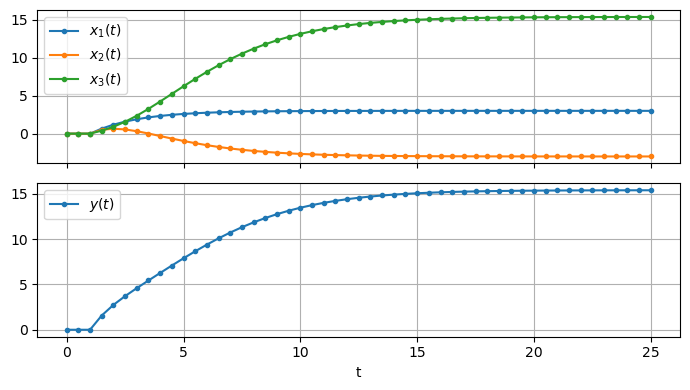

In [11]:
def make_step_response_plot(t, X, Y, figsize=(7, 4)):

    fig, axes = plt.subplots(2, 1, sharex=True, figsize=figsize)

    N = X.shape[1]
    x_labels = [f"$x_{i+1}(t)$" for i in range(N)]
    y_label = "$y(t)$"

    ax = axes[0]
    ax.plot(t, X, marker='.', linestyle='-', label=x_labels)
    ax.grid()
    ax.legend()

    ax = axes[1]
    ax.plot(t, Y, marker='.', linestyle='-', label=y_label)
    ax.set_xlabel('t')
    ax.grid()
    ax.legend()

    return fig, ax  

# Example
N = 3
p = 0.5
c = np.ones(N)

# Simulation time
t_stop = 25
T = 0.5
nT = int(np.ceil(t_stop / T))
t = ca.DM(T * np.arange(nT+1))

step_response = make_step_response_function(N, T, nT)

t = T * np.arange(nT+1)

X, Y = step_response(p, c)
X = np.array(X)
Y = np.array(Y)

fig, ax = make_step_response_plot(t, X, Y)
plt.tight_layout()
plt.show()

In [22]:
def create_interactive_step_response_plot():
    """
    Creates an interactive step response plot with sliders for parameters p and c vector.
    """
    
    # Fixed parameters
    N = 5
    nT = 20
    T = 0.5
    t = T * np.arange(nT+1)
    
    # Create the step response function
    step_response = make_step_response_function(N, T, nT)
    
    # Create figure and subplots
    fig = plt.figure(figsize=(10, 8))
    
    # Main plot area - leave space at bottom for sliders
    gs = fig.add_gridspec(2, 1, height_ratios=[1, 1], hspace=0.1, 
                         left=0.1, right=0.95, top=0.85, bottom=0.35)
    
    ax1 = fig.add_subplot(gs[0])  # States plot
    ax2 = fig.add_subplot(gs[1])  # Output plot
    
    # Initial parameter values
    p_init = 0.5
    c_init = np.ones(N)
    
    # Compute initial step response
    X_init, Y_init = step_response(p_init, c_init)
    X_init = np.array(X_init)
    Y_init = np.array(Y_init)
    
    # Create initial plots
    x_labels = [f"$x_{i+1}(t)$" for i in range(N)]
    y_label = "$y(t)$"
    
    # Plot states
    lines_x = []
    for i in range(N):
        line, = ax1.plot(t, X_init[:, i], marker='.', linestyle='-', label=x_labels[i])
        lines_x.append(line)
    
    ax1.grid(True)
    ax1.legend()
    ax1.set_ylabel('States')
    ax1.set_title('Laguerre Model Step Response')
    
    # Plot output
    line_y, = ax2.plot(t, Y_init, marker='.', linestyle='-', label=y_label, color='red')
    ax2.grid(True)
    ax2.legend()
    ax2.set_xlabel('Time (t)')
    ax2.set_ylabel('Output')
    
    # Create slider axes
    slider_height = 0.03
    slider_spacing = 0.04
    slider_left = 0.15
    slider_width = 0.7
    
    # Parameter p slider
    ax_p = fig.add_axes([slider_left, 0.25, slider_width, slider_height])
    slider_p = Slider(ax_p, 'p', 0.1, 0.9, valinit=p_init, valfmt='%.2f')
    
    # Parameter c sliders
    sliders_c = []
    for i in range(N):
        ax_c = fig.add_axes([slider_left, 0.25 - (i+1)*slider_spacing, slider_width, slider_height])
        slider_c = Slider(ax_c, f'c[{i+1}]', 0.1, 2.0, valinit=c_init[i], valfmt='%.2f')
        sliders_c.append(slider_c)
    
    def update_plot(val=None):
        """Update the plot when sliders change"""
        # Get current parameter values
        p_current = slider_p.val
        c_current = np.array([slider.val for slider in sliders_c])
        
        try:
            # Compute new step response
            X_new, Y_new = step_response(p_current, c_current)
            X_new = np.array(X_new)
            Y_new = np.array(Y_new)
            
            # Update state plots
            for i, line in enumerate(lines_x):
                line.set_ydata(X_new[:, i])
            
            # Update output plot
            line_y.set_ydata(Y_new)
            
            # Rescale axes if needed
            ax1.relim()
            ax1.autoscale_view()
            ax2.relim()
            ax2.autoscale_view()
            
            # Redraw
            fig.canvas.draw_idle()
            
        except Exception as e:
            print(f"Error updating plot: {e}")
    
    # Connect sliders to update function
    slider_p.on_changed(update_plot)
    for slider in sliders_c:
        slider.on_changed(update_plot)
    
    # Instructions
    fig.suptitle('Interactive Step Response Plot\nAdjust sliders to change parameters p and c', 
                 fontsize=12, y=0.95)
    
    plt.show()
    
    return fig, (ax1, ax2), slider_p, sliders_c

# Usage instructions for Jupyter notebook:
print("You MUST use %matplotlib notebook for interactive matplotlib sliders.")


You MUST use %matplotlib notebook for interactive matplotlib sliders.


In [33]:
%matplotlib notebook

fig, axes, slider_p, sliders_c = create_interactive_step_response_plot()

<IPython.core.display.Javascript object>

## Alternative method using ipywidgets

In [26]:
from ipywidgets import interact, FloatSlider, VBox, HBox
from IPython.display import display

def create_ipywidgets_step_response(N, T, nT, figsize=(7, 4)):
    """
    Creates an interactive step response plot using ipywidgets.
    Requires: pip install ipywidgets
    """
    
    # Create the step response function
    step_response = make_step_response_function(N, T, nT)
    
    # Time index
    t = T * np.arange(nT+1)
    
    def plot_step_response(**params):
        """Plot function that gets called when sliders change"""

        # Get parameter values
        p = params.pop('p')
        c = []
        for i in range(len(params)):
            name = f'c{i+1}'
            c.append(params[name])
        c = np.array(c)
    
        # Clear previous plots
        plt.clf()
        
        # Set up the figure
        fig, axes = plt.subplots(2, 1, sharex=True, figsize=figsize)
        
        try:
            # Compute step response
            X, Y = step_response(p, c)
            X = np.array(X)
            Y = np.array(Y)
            
            # Plot states
            x_labels = [f"$x_{i+1}(t)$" for i in range(N)]
            ax = axes[0]
            for i in range(N):
                ax.plot(t, X[:, i], marker='.', linestyle='-', label=x_labels[i])
            ax.grid(True)
            ax.legend()
            ax.set_ylabel('States')
            ax.set_title('Laguerre Model Step Response')

            # Plot output
            ax = axes[1]
            ax.plot(t, Y, marker='.', linestyle='-', label='$y(t)$', color='red')
            ax.set_xlabel('Time (t)')
            ax.set_ylabel('Output')
            ax.grid(True)
            ax.legend()

            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"Error computing step response: {e}")

    sliders = {
        'p': FloatSlider(value=0.5, min=0.1, max=1.0, step=0.1, description='p:')
    }
    for i in range(N):
        name = f'c{i+1}'
        sliders[name] = FloatSlider(value=1.0, min=-2.0, max=2.0, step=0.1, description=f'c[{i+1}]:')
    
    # Create interactive widget
    interact(
        plot_step_response,
        **sliders
    )

# Usage for ipywidgets version:
print("To use the ipywidgets version:")
print("1. Install: pip install ipywidgets")
print("2. Use: %matplotlib inline")
print("3. Run: create_ipywidgets_step_response()")
print()
print("This version recreates the entire plot when sliders change,")
print("which works well with any matplotlib backend!")

To use the ipywidgets version:
1. Install: pip install ipywidgets
2. Use: %matplotlib inline
3. Run: create_ipywidgets_step_response()

This version recreates the entire plot when sliders change,
which works well with any matplotlib backend!


In [31]:
%matplotlib inline

# Polynomial order
N = 5

# Simulation time
t_stop = 25
T = 0.5
nT = int(np.ceil(t_stop / T))

create_ipywidgets_step_response(N, T, nT)

interactive(children=(FloatSlider(value=0.5, description='p:', max=1.0, min=0.1), FloatSlider(value=1.0, descr…